In [2]:
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 52.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.3/934.3 kB 46.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 65.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 76.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 80.2 MB/s eta 0:00:00


In [3]:
import pennylane as qml
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import sys

# Setting our constants
sys.path.append('..')

/usr/local/lib/python3.12/dist-packages/pennylane/__init__.py:209: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.6.2. You have version 0.7.2 installed. Please downgrade JAX to 0.6.2 to avoid runtime errors using python -m pip install jax~=0.6.0 jaxlib~=0.6.0
  warnings.warn(


In [4]:
!wget https://raw.githubusercontent.com/aifactory-team/AFCompetition/main/9245/train_X.npy
!wget https://raw.githubusercontent.com/aifactory-team/AFCompetition/main/9245/train_y.npy

--2025-12-15 04:36:19--  https://raw.githubusercontent.com/aifactory-team/AFCompetition/main/9245/train_X.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32896 (32K) [application/octet-stream]
Saving to: ‘train_X.npy’

train_X.npy         100%[===================>]  32.12K  --.-KB/s    in 0.01s   

2025-12-15 04:36:19 (3.02 MB/s) - ‘train_X.npy’ saved [32896/32896]

--2025-12-15 04:36:19--  https://raw.githubusercontent.com/aifactory-team/AFCompetition/main/9245/train_y.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 256 [

In [5]:
train_X = np.load("train_X.npy")
train_y = np.load("train_y.npy")

In [7]:
import pennylane as qml
import torch
import torch.nn as nn
import torch.optim as optim
from pennylane import numpy as np
from torch.utils.data import TensorDataset, DataLoader

# ==========================================
# 1. Inference (Model Prediction) - 기존 유지
# ==========================================
def get_predictions(model, inputs):
    """Run inference on inputs using the trained model."""
    model.eval()
    with torch.no_grad():
        outputs = model(inputs)
        predicted_labels = torch.argmax(outputs, dim=1)
    return predicted_labels.cpu().numpy()

def data_to_tensor(X, y):
    tensor_X = torch.tensor(X, dtype=torch.complex64)
    tensor_y = torch.tensor(y, dtype=torch.long)
    return tensor_X, tensor_y

t_train_X, t_train_y = data_to_tensor(train_X, train_y)
train_dataset = TensorDataset(t_train_X, t_train_y)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

In [8]:
import pennylane as qml
import torch
import torch.nn as nn
import torch.optim as optim
from pennylane import numpy as np
from torch.utils.data import TensorDataset, DataLoader

n_qubits = 8
dev = qml.device("default.qubit", wires=n_qubits)
device = "cuda" if torch.cuda.is_available() else "cpu"

def Quantum_classifier(params):
    wires = [i for i in range(n_qubits)]
    params = params.reshape(-1,3,8)
    for layer in range(params.shape[0]-1):
        for i, wire in enumerate(wires):
            qml.Rot(params[layer,0,i], params[layer,1,i], params[layer,2,i], wires=wire)
        for i in range(len(wires)-1):
            qml.CNOT(wires=[wires[i], wires[i+1]])
    for i, wire in enumerate(wires):
        qml.Rot(params[-1,0,i], params[-1,1,i], params[-1,2,i], wires=wire)



@qml.qnode(dev, interface='torch')
def linear_2qubit_block(state, params):
    wires = [i for i in range(n_qubits)]
    qml.StatePrep(state, wires=wires)
    Quantum_classifier(params)

    return qml.probs(wires=[6,7])
class QNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.total_params = 5*3*8  # 15 layers, 3 params per qubit, 8 qubits
        torch.manual_seed(42)
        self.params = nn.Parameter(torch.randn(self.total_params, requires_grad=True)*0.01)

    def forward(self, x):
        preds = linear_2qubit_block(x, self.params)
        return preds

model = QNN()
model.to(device=device)
optimizer = optim.Adam(model.parameters(), lr=0.05)


epochs = 200
loss_history = []
acc_history = []
print(f"--- Training QNN (Params: {model.total_params}) ---")

def quantum_phase_loss(probs, labels):
    """
    Custom Loss Function based on Eq. (10) of the paper.
    Loss = 1 - (Probability of the correct class)
    """
    # probs shape: (batch_size, 4)
    # labels shape: (batch_size,)


    batch_size = probs.shape[0]

    # 정답 인덱스의 확률 추출 (Advanced Indexing)
    label_one_hot = torch.nn.functional.one_hot(labels, num_classes=probs.shape[1])
    probs = probs
    probs = probs / torch.sum(probs, dim=1, keepdim=True)

    loss = -torch.sum(label_one_hot*torch.log(probs), dim=1)

    # 배치 평균 반환
    return torch.mean(loss)


for epoch in range(epochs):
    total_loss = 0
    correct = 0

    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        predictions = model(batch_X.to(device=device))
        loss = quantum_phase_loss(predictions, batch_y.to(device=device))
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        predicted_classes = torch.argmax(predictions, dim=1)
        batch_y = batch_y.to(predicted_classes.device)
        correct += (predicted_classes == batch_y).sum().item()

    avg_loss = total_loss / len(train_loader)
    avg_acc = correct / len(train_dataset)
    loss_history.append(avg_loss)
    acc_history.append(avg_acc)
    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch+1:02d} | Loss: {avg_loss:.4f} | Train Acc: {avg_acc:.4f}")

--- Training QNN (Params: 120) ---
Epoch 20 | Loss: 0.5615 | Train Acc: 0.8750
Epoch 40 | Loss: 0.5068 | Train Acc: 0.9375
Epoch 60 | Loss: 0.4838 | Train Acc: 0.9375
Epoch 80 | Loss: 0.4811 | Train Acc: 0.9375
Epoch 100 | Loss: 0.4855 | Train Acc: 0.9375
Epoch 120 | Loss: 0.4785 | Train Acc: 0.9375
Epoch 140 | Loss: 0.4814 | Train Acc: 0.9375
Epoch 160 | Loss: 0.4791 | Train Acc: 0.9375
Epoch 180 | Loss: 0.4781 | Train Acc: 0.9375
Epoch 200 | Loss: 0.4803 | Train Acc: 0.9375


(<Figure size 2200x900 with 1 Axes>, <Axes: >)

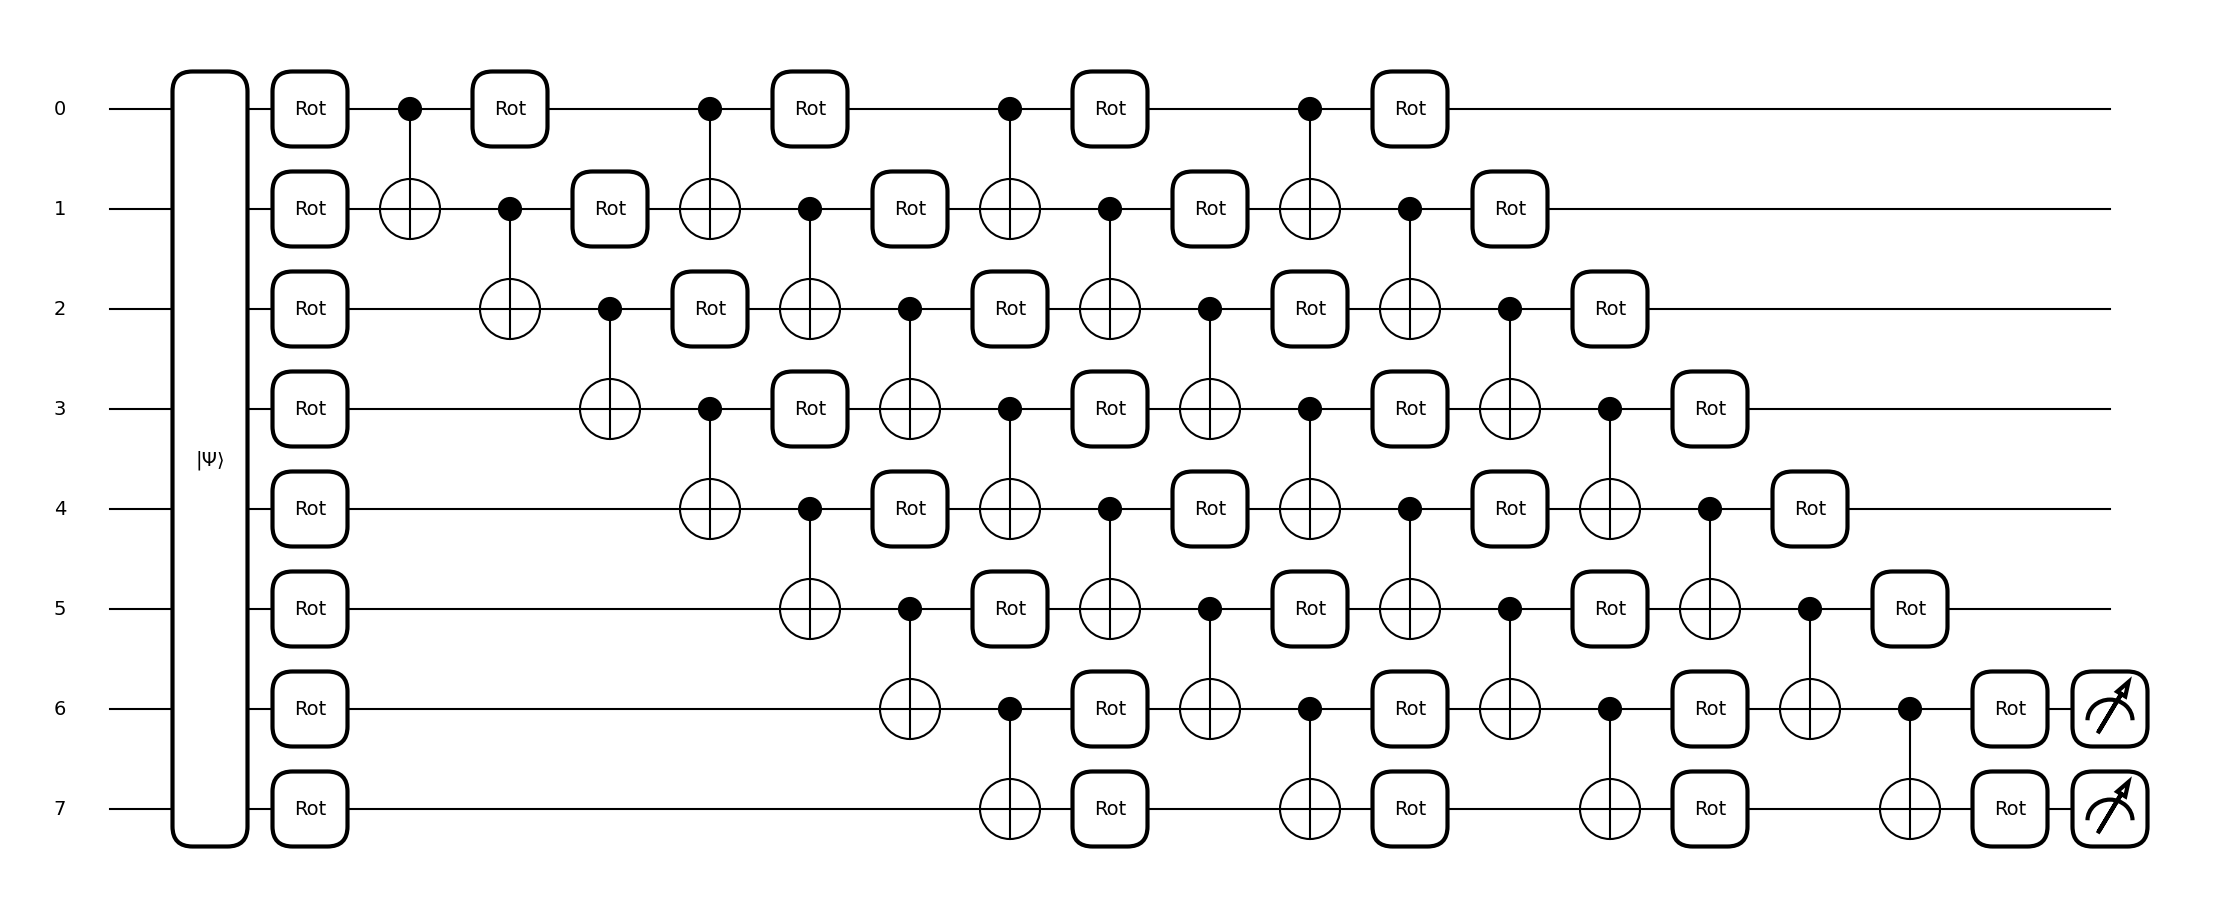

In [ ]:
qml.draw_mpl(linear_2qubit_block)(batch_X,model.params)

In [9]:
import json

# 1. Specify measurement qubits
measurements = [6, 7]

# 2. Extract trained parameters
params = model.params.detach().cpu().numpy()

# 3. Define circuit for QASM conversion (Ansatz only, no StatePrep or Measurement)
@qml.qnode(dev, interface='torch')
def Classifier(params):
    Quantum_classifier(params)

# 4. Generate OpenQASM string
qasm_data = qml.to_openqasm(Classifier, measure_all=False)(params)

print(f"✅ Measurement Qubits: {measurements}")
print(f"✅ QASM Data Generated (Length: {len(qasm_data)} characters)")
print("--- QASM Preview (First 10 lines) ---")
print("\n".join(qasm_data.split('\n')[:10]))


with open("./baseline.json", "w") as f:
    json.dump({
        "qasm": qasm_data,
        "measurements": measurements
    }, f)
print("✅ Submission file 'baseline.json' created.")

✅ Measurement Qubits: [6, 7]
✅ QASM Data Generated (Length: 3040 characters)
--- QASM Preview (First 10 lines) ---
OPENQASM 2.0;
include "qelib1.inc";
qreg q[8];
creg c[8];
rz(0.057319336) q[0];
ry(-0.0026217776) q[0];
rz(-0.024432804) q[0];
rz(0.27092808) q[1];
ry(0.002669789) q[1];
rz(-0.28873712) q[1];
✅ Submission file 'baseline.json' created.


In [10]:
from google.colab import files
files.download('baseline.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>